# Transformers in PyTorch

Deep learning has made huge progress, especially in Natural Language Processing (NLP), thanks to transformer architectures. Although transformers became popular in NLP, their potential extends beyond text. They are gaining attention for time-series forecasting, which involves predicting future values based on past data—similar to how NLP models handle sequences of words. For example, forecasting stock prices or electricity usage is conceptually similar to translating one language to another. Both require understanding patterns and dependencies across sequences.

This code lab explores how transformers can be adapted for time-series prediction using PyTorch.

As is practice in this course, `XXXX` means you have to fill in the correct code. If you are following along and not in our course at the University of Rhode Island, you can find the answers in the `05-transformers-ANSWERKEY.ipynb` file in the repository.


## Step 1: Imports

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Step 2: Create Synthetic Data

We will generate a noisy sine wave to practice implementing a transformer for a regression task.

In [ ]:
# Generate synthetic time series data
time = np.arange(0, 1000, 0.1)
amplitude = np.sin(time) + np.random.normal(0, 0.2, len(time))

# Convert to DataFrame
df = pd.DataFrame({'amplitude': amplitude})

# Split the data
train_size = int(len(df) * 0.8)
df_train = df[:train_size]
df_test = df[train_size:]

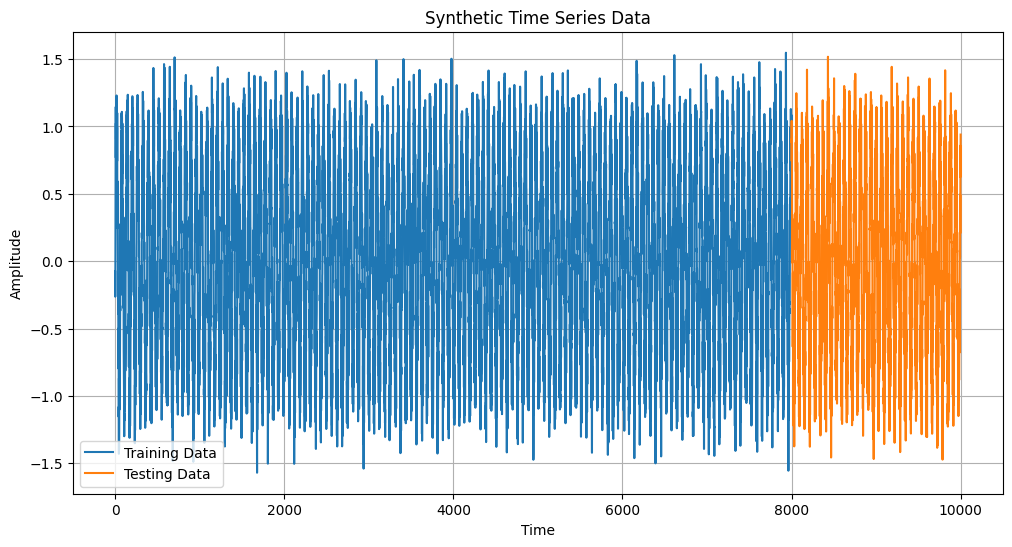

In [ ]:
# Visualize the data
plt.figure(figsize=(12, 6))
plt.plot(df_train['amplitude'], label='Training Data')
plt.plot(df_test['amplitude'], label='Testing Data')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.title('Synthetic Time Series Data')
plt.legend()
plt.grid(True)
plt.show()

As we've done for several other labs, we need to create many sequences from our larger dataset.

In [ ]:
# sequence data preparation
seq_length = 10

def to_sequences(seq_size, data):
    x = []
    y = []
    for i in range(len(data) - seq_size - 1):
        x.append(data[i:(i + seq_size)].tolist()) # Convert to list before appending
        y.append(data[i + seq_size].item()) # Extract the scalar value before appending
    return torch.tensor(x, dtype=torch.float32).view(-1, seq_size, 1), torch.tensor(y, dtype=torch.float32).view(-1, 1)

In [ ]:
# Extract the 'amplitude' column as a NumPy array
train_array = df_train['amplitude'].values
test_array = df_test['amplitude'].values

# Convert the NumPy array to a PyTorch tensor
train_tensor = torch.tensor(train_array, dtype=torch.float32).view(-1, 1)
test_tensor = torch.tensor(test_array, dtype=torch.float32).view(-1, 1)

# Call the to_sequences function
x_train, y_train = to_sequences(seq_length, train_tensor)
x_test, y_test = to_sequences(seq_length, test_tensor)

We can now make our data into `TensorDatasets` and create `DataLoaders` for batch processing.

In [ ]:
# Setup data loaders for batch
train_dataset = TensorDataset(x_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

## Step 3: Position Encoding

Transformers process all tokens at once rather than step-by-step like RNNs and LSTMs. This makes them faster but means they don’t naturally understand the order of tokens in a sequence. To fix this, we use positional encoding, which adds order information to token embeddings.

Positional encodings are vectors added to token embeddings to help the model recognize positions in a sequence. A common way to generate them is with sinusoidal functions, which create unique patterns for each position.

These functions help the model generalize to longer sequences it hasn’t seen before. Using simple position numbers instead wouldn’t work well because they might interfere with the trained embedding values.

The `PositionalEncoding` class below helps provide information about the position of tokens in the input sequence. Let’s break down each part:

* `__init__(self, d_model, dropout=0.1, max_len=5000)`: The constructor for the positional encoding layer.
  * `d_model` is the size of the embedding dimension (i.e., the number of features for each token).
  * `dropout` specifies the dropout rate to apply to the positional encodings for regularization.
  * `max_len` is the maximum sequence length that the positional encoding will support.
  * `self.dropout` = nn.Dropout(p=dropout): Creates a dropout layer that will be applied to the positional encodings to avoid overfitting. The dropout probability is controlled by `dropout`.
* `pe = torch.zeros(max_len, d_model)`: Creates a tensor pe that will hold the positional encoding values. It is of shape `(max_len, d_model)` where `max_len` is the maximum sequence length, and `d_model` is the embedding dimension.
* `position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)`: This line generates a tensor of shape `(max_len, 1)` representing the position of each token in the sequence. The `unsqueeze(1)` makes it a column vector, turning it into shape `(max_len, 1)` where each row represents the position of a token (e.g., 0, 1, 2, ..., max_len-1).
* `div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))`: This creates a tensor that holds the scaling factors used for the positional encoding. The formula for the positional encoding involves applying a sine and cosine function with different frequencies for even and odd positions in the embedding space. This line computes the scaling factors for each dimension (`d_model`). The scaling is done exponentially, with the range of values chosen such that the frequencies vary smoothly across dimensions.
* `pe[:, 0::2] = torch.sin(position * div_term)`: For even-indexed dimensions in the pe tensor (i.e., 0, 2, 4, ...), we assign the sine of the product of the position and the scaling factors `div_term`. This creates sinusoidal functions with different frequencies for different dimensions.
* `pe[:, 1::2] = torch.cos(position * div_term)`: For odd-indexed dimensions (i.e., 1, 3, 5, ...), we assign the cosine of the same product. This gives alternating sine and cosine patterns for each position in the sequence.
* `pe = pe.unsqueeze(0).transpose(0, 1)`: The `unsqueeze(0)` adds a batch dimension at the start, turning the shape from `(max_len, d_model)` to `(1, max_len, d_model)`. Then, the `transpose(0, 1)` swaps the batch and sequence dimensions, making the final shape `(max_len, 1, d_model)`. This is the expected shape for adding to the input sequence.
* `self.register_buffer('pe', pe)`: This registers the positional encoding as a buffer, which means that it will be stored as part of the model’s state but won’t be considered a parameter (i.e., it won’t be updated during training). It is part of the model’s architecture and is used in the forward pass to add positional information.
* `x = x + self.pe[:x.size(0), :]`: During the forward pass, the positional encoding is added to the input x. The positional encoding is sliced to match the sequence length of the input (x.size(0)) to ensure the correct dimensionality. This addition allows the model to incorporate the positional information into the token embeddings.
* `return self.dropout(x)`: Finally, the result is passed through the dropout layer to apply regularization before returning the output.

In [ ]:
# Positional Encoding for Transformer
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)  # tensor to hold position values
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # tensor for position of each token
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))  # scaling for functions
        pe[:, 0::2] = torch.sin(position * div_term)  # sin functions for even dimensions
        pe[:, 1::2] = torch.cos(position * div_term)  # cosine functions for odd dimensions
        pe = pe.unsqueeze(0).transpose(0, 1)  # add batch dimensions and flip
        self.register_buffer('pe', pe)  # store as part of model state but not a parameter

    def forward(self, x):
        x = x + self.pe[:x.size(0), :]  # add the position vector to the original
        return self.dropout(x)  # add some dropout for regularization

## Step 4: Implementing a Transformer
We will now implement a transformer model for time series forecasting using PyTorch. It will include:

* An embedding layer to transform inputs to the right dimensions.
* Positional encodings to preserve order information.
* A transformer encoder to process the sequence.
* An output layer to generate predictions.

The three key parameters in a Transformer model—`d_model`, `nhead`, and `num_layers`—affect its performance, computational cost, and ability to generalize.

  * **`d_model`**: This is the size of the input embeddings. A higher d_model allows the model to learn more complex patterns but increases computation and the risk of overfitting. Fortunately, normalization layers help manage these issues.

  * **`nhead`**: This sets the number of attention heads in multi-head attention. More heads let the model focus on different parts of the input simultaneously, improving its ability to capture context. However, adding too many heads increases computational cost and may not always improve performance.

  * **`num_layers`**: This controls the number of stacked Transformer encoder (or decoder) layers. More layers help the model learn deeper relationships in the data, but after a certain point, the benefits level off, and overfitting can become a problem. Training very deep models may require techniques like gradient clipping or learning rate adjustments.

Choosing the right values for these parameters depends on the task, dataset, and available computing power. Finding the best settings often requires experimentation.




In [ ]:
# Model definition using Transformer
class TransformerModel(nn.Module):
    def __init__(self, input_dim=1, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()

        self.encoder = nn.Linear(input_dim, d_model)  # project into higher embedding space
        self.pos_encoder = PositionalEncoding(d_model, dropout)  # add positional encoding
        encoder_layers = nn.TransformerEncoderLayer(d_model, nhead)  # defining attention and FF network block
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)  # a stack of encoder blocks
        self.output_layer = nn.Linear(d_model, 1)  # make final predictions

    def forward(self, x):
        x = self.encoder(x)
        x = self.pos_encoder(x)
        x = self.transformer_encoder(x)
        x = self.output_layer(x[:, -1, :])  # `(batch_size, seq_length, d_model)`, we take last sample
        return x

model = TransformerModel().to(device)

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


## Step 5: Training the Model

Training a transformer-based model follows similar principles to other neural networks. Like other deep learning models, it benefits from batch training, which improves efficiency and helps generalization by updating weights based on multiple samples at once, rather than relying on single data points.

In [ ]:
# Train the model
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
epochs = 10

for epoch in range(epochs):
    model.train()
    for batch in train_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()
        outputs = model(x_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {loss:.4f}")

Epoch 1/10, Training Loss: 0.2243
Epoch 2/10, Training Loss: 0.3019
Epoch 3/10, Training Loss: 0.4299
Epoch 4/10, Training Loss: 0.5879
Epoch 5/10, Training Loss: 0.5575
Epoch 6/10, Training Loss: 0.7270
Epoch 7/10, Training Loss: 0.2069
Epoch 8/10, Training Loss: 0.1285
Epoch 9/10, Training Loss: 0.1952
Epoch 10/10, Training Loss: 0.1045


## Step 6: Evaluate the Model

We can now evaluate the performance of this model. We first need to set the model to eval and predict on our test data.

In [ ]:
# Evaluate the model on the test set
model.eval()
predictions = []
actuals = []

with torch.no_grad():
    for batch in test_loader:
        x_batch, y_batch = batch
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)

        y_pred = model(x_batch)
        predictions.append(y_pred.cpu().numpy())
        actuals.append(y_batch.cpu().numpy())

# Flatten the lists into a single array
predictions = np.concatenate(predictions)
actuals = np.concatenate(actuals)

Let's calculate some common metrics to quantify how close our predictions are.

* **Mean Absolute Error (MAE)** is calculated using torch.abs to compute the absolute differences between true and predicted values, then averaging them using torch.mean.
* **Mean Squared Error (MSE)** is computed by squaring the differences and averaging them, using torch.mean as well.
* **R-squared (R²)** is calculated by:
  * R² = `1 - ss_residual / ss_total`.
  * `ss_total`: the total sum of squares (variance of the true values).
  * `ss_residual`: the residual sum of squares (difference between true and predicted values).

In [ ]:
# Compute evaluation metrics
def evaluate_metrics(true_values, predicted_values):
    # Convert to tensors if they're not already
    true_values = true_values.float()
    predicted_values = predicted_values.float()

    # Mean Absolute Error (MAE)
    mae = torch.mean(torch.abs(true_values - predicted_values))

    # Mean Squared Error (MSE)
    mse = torch.mean((true_values - predicted_values) ** 2)

    # R-squared (R²)
    ss_total = torch.sum((true_values - torch.mean(true_values)) ** 2)
    ss_residual = torch.sum((true_values - predicted_values) ** 2)
    r2 = 1 - ss_residual / ss_total

    return mae.item(), mse.item(), r2.item()

In [ ]:
# Get the actual values and the predicted values as PyTorch tensors
actual_values = torch.tensor(actuals, dtype=torch.float32)
predicted_values = torch.tensor(predictions, dtype=torch.float32)

# Evaluate the model
mae, mse, r2 = evaluate_metrics(actual_values, predicted_values)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Finally, let's plot the data to see how it looks.

In [ ]:
# Plot predicted vs actual values
plt.figure(figsize=(12, 6))
plt.plot(actuals, label='Actual', color='blue')
plt.plot(predictions, label='Predicted', color='red', linestyle='--')
plt.xlabel('Time Step')
plt.ylabel('Amplitude')
plt.title('Predicted vs Actual Values')
plt.legend()
plt.grid(True)
plt.show()

Hmmm, I think we can do better!

## Step 7: Challenge Time!

Now that we’ve successfully implemented and evaluated the transformer model, it’s time for a challenge. Below are several areas where you can explore improvements, but feel free to try your own ideas too!

**1. Hyperparameter Tuning:**
  * Increase the number of layers in the transformer model. This can help capture more complex relationships in the data.
  * Adjust the number of attention heads (`nhead`). Try increasing or decreasing it to see how it affects performance.
  * Change the model dimension (`d_model`) and the size of the feedforward layer (`dim_feedforward`). Larger values might allow the model to capture more complex patterns, but they also increase the risk of overfitting.

**2. Sequence Length:**
  * Try increasing the sequence length (`seq_length`). A longer history might help the model predict more accurately, but it also increases the computational cost.
  * Alternatively, decrease the sequence length to see if the model performs better with less data.

**3. Learning Rate:**
  * Experiment with different learning rates to optimize the training process. You can try smaller learning rates like 1e-6 or larger ones like 1e-3 to see how it affects convergence.

**4. Optimizer:**
  * Try using other optimizers like SGD or RMSprop to see if they perform better for this problem.

**5. Data Augmentation:**
  * If your data allows it, try applying data augmentation techniques such as noise addition, time warping, or random scaling to make the model more robust.

**6. Early Stopping:**
  * Implement early stopping to prevent overfitting. If the model’s performance stops improving after a certain number of epochs, halt training early.

**7. Regularization:**
  * Try increasing the dropout rate in the transformer layers to help prevent overfitting.
  * Experiment with L2 regularization (weight decay) to penalize large model weights.

**8. Loss Function:**
  * You are using MSELoss as the loss function.Experiment with other loss functions like Huber Loss (less sensitive to outliers) or Log-Cosh Loss (smooths out large errors).

**9. Model Architecture:**
  * Consider adding additional components to the transformer model. For example, you could introduce a multi-scale approach, where the model predicts at different time scales and combines them for the final prediction.

**Challenge Task:**
* Try different hyperparameters and see if you can achieve better results on the test set.
* Visualize how your changes affect the training and testing loss. Plot the metrics after implementing each modification and compare the model performance.
* Evaluate the final model using the evaluation metrics (MAE, MSE, R²), and discuss the trade-offs between overfitting and underfitting as you experiment with different strategies.
* Track your experiments with tools like MLFlow or TensorBoard to monitor the training process and compare results from different model configurations.

Good luck! Have fun experimenting with the model and share what improvements you find!